In [1]:
import os
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torch.utils.data import Dataset

from habitat_sim.utils.data.dataextractor import ImageExtractor

In [2]:
NUM_CLASSES = 10
IMG_HEIGHT = IMG_WIDTH = 32

# Credit: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model


def collate_fn(batch):
    return tuple(zip(*batch))


class MyDataset(Dataset):
    def __init__(self, extractor, root, transform=None):
        self.extractor = extractor
        self.root = root
        self.transform = transform
        self.imgs = list(sorted(os.listdir(os.path.join(root, "sample_images"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "sample_masks"))))
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "sample_images", self.imgs[idx])
        mask_path = os.path.join(self.root, "sample_masks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        mask = mask[:, :, 0]
        
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        # split the color-encoded mask into a set
        # of binary masks
        #masks = mask == obj_ids[:, None, None]
        
        masks = np.array([mask == obj_id for obj_id in obj_ids])

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        if self.transform:
            img = self.transform(img)

        return img, target
    
    
class HabitatDataset(Dataset):
    def __init__(self, extractor):
        self.extractor = extractor
        
    def __len__(self):
        return len(self.extractor.poses)
    
    def __getitem__(self, idx):
        return self.extractor[idx]
    

In [3]:
# Setup training environment
N_EPOCHS = 10

model = get_model_instance_segmentation(NUM_CLASSES)

# transform = T.Compose([T.ToTensor()])
# dataset = MyDataset(None, root="./data/sample_data/", transform=transform)
# data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True, num_workers=4,
#                                           collate_fn=collate_fn)
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# model.to(device)

# params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

scene_filepath = "../../data/scene_datasets/habitat-test-scenes/skokloster-castle.glb"
extractor = ImageExtractor(scene_filepath)

I0204 11:21:03.826827 25504 simulator.py:131] Loaded navmesh ../../data/scene_datasets/habitat-test-scenes/skokloster-castle.navmesh


sim_cfg.physics_config_file = ./data/default.phys_scene_config.json


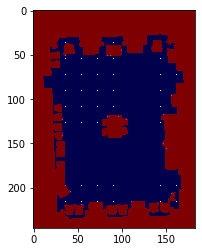

In [6]:
dataset = HabitatDataset(extractor)



In [46]:
# Example of training
from examples.instance_segmentation.engine import train_one_epoch
import examples.instance_segmentation.utils

for epoch in range(N_EPOCHS):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()
    
    
# # For Training
# images, targets = next(iter(data_loader))
# images = list(image for image in images)
# targets = [{k: v for k, v in t.items()} for t in targets]
# output = model(images,targets)   # Returns losses and detections
# # For inference
# model.eval()
# x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
# predictions = model(x)           # Returns predictions

Epoch: [0]  [0/1]  eta: 0:00:32  lr: 0.005000  loss: 5.5464 (5.5464)  loss_classifier: 2.3515 (2.3515)  loss_box_reg: 0.1789 (0.1789)  loss_mask: 2.0460 (2.0460)  loss_objectness: 0.7072 (0.7072)  loss_rpn_box_reg: 0.2628 (0.2628)  time: 32.9171  data: 0.3392
Epoch: [0] Total time: 0:00:32 (32.9636 s / it)
Epoch: [1]  [0/1]  eta: 0:00:34  lr: 0.005000  loss: 2.8464 (2.8464)  loss_classifier: 1.3775 (1.3775)  loss_box_reg: 0.2144 (0.2144)  loss_mask: 0.8798 (0.8798)  loss_objectness: 0.1465 (0.1465)  loss_rpn_box_reg: 0.2282 (0.2282)  time: 34.6248  data: 0.4232
Epoch: [1] Total time: 0:00:34 (34.8419 s / it)
Epoch: [2]  [0/1]  eta: 0:00:35  lr: 0.005000  loss: 2.0976 (2.0976)  loss_classifier: 0.5855 (0.5855)  loss_box_reg: 0.2643 (0.2643)  loss_mask: 0.9889 (0.9889)  loss_objectness: 0.0590 (0.0590)  loss_rpn_box_reg: 0.1998 (0.1998)  time: 35.3224  data: 0.4360
Epoch: [2] Total time: 0:00:35 (35.5724 s / it)
Epoch: [3]  [0/1]  eta: 0:00:35  lr: 0.000500  loss: 1.8664 (1.8664)  loss_c